In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/GMM localization/bayes-filter-codes

/content/gdrive/.shortcut-targets-by-id/1Lnjq7iMIyI0cZJE7KeUVnfGWVqiJgvJ7/bayes-filter-codes


In [3]:
%pip install filterpy
!pip install plyfile
!pip install pyquaternion

     |████████████████████████████████| 177 kB 5.3 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=9673c7ffb905a6fa222805235baea01190b0ffa2ae68a2f441374fbd8c287515
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy


In [4]:
%matplotlib inline
import book_format
book_format.set_style()
import kf_book.pf_internal as pf_internal
from numpy.random import uniform
from numpy.random import randint
from filterpy.monte_carlo import systematic_resample
from filterpy.monte_carlo import stratified_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed
from scipy.spatial.transform import Rotation as R
from sklearn.preprocessing import MinMaxScaler
from sklearn import mixture
from numpy.random import random
from scipy.stats import multivariate_normal
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

In [5]:
# read pointcloud data (scene-01)
from plyfile import PlyData, PlyElement

plydata = PlyData.read('/content/gdrive/MyDrive/GMM localization/12.ply')

x = plydata.elements[0].data['x']
y = plydata.elements[0].data['y']
z = plydata.elements[0].data['z']
data = np.vstack((x,y,z)).T
np.random.shuffle(data)
pcdata = np.array(data[0:12500,:])

In [6]:
gmm = mixture.GaussianMixture(n_components = 30, covariance_type = 'diag', init_params='random', reg_covar=0.02) #, reg_covar=0.0001
gmm.fit(pcdata)

GaussianMixture(covariance_type='diag', init_params='random', n_components=30,
                reg_covar=0.02)

In [7]:
means = gmm.means_
covs = gmm.covariances_
mixp = gmm.weights_

In [8]:
def create_uniform_particles(x_range, y_range, z_range, N):
    particles = np.empty((N, 7)) #np.empty((N, 3))
    particles[:, 0] = np.zeros(N) #uniform(r_range[0], r_range[1], size=N)
    particles[:, 1] = np.zeros(N) #uniform(r_range[0], r_range[1], size=N)
    particles[:, 2] = np.zeros(N) #uniform(r_range[0], r_range[1], size=N)
    particles[:, 3] = np.zeros(N) #uniform(r_range[0], r_range[1], size=N)
    particles[:, 4] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 5] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 6] = uniform(z_range[0], z_range[1], size=N)
    return particles


def predict(particles, u, std):
    """ move according to control input u (x change, y change, z change)
    with noise Q (std x, std y, std z)`"""
    N = len(particles)
    # move in the (noisy) commanded direction
    particles[:, 0] += u[0] + (randn(N) * std[0])
    particles[:, 1] += u[1] + (randn(N) * std[0])
    particles[:, 2] += u[2] + (randn(N) * std[0])
    particles[:, 3] += u[3] + (randn(N) * std[0])
    particles[:, 4] += u[4] + (randn(N) * std[1])
    particles[:, 5] += u[5] + (randn(N) * std[2])
    particles[:, 6] += u[6] + (randn(N) * std[3])


def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 4:7]
    ori = particles[:, 0:4]
    mean = np.average(pos, weights=weights, axis=0)
    mean_ori = np.average(ori, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, mean_ori, var


def neff(weights):
    return 1. / np.sum(np.square(weights))


def resample_from_index(particles, weights, indexes):
    #print("Weights:",weights)
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [9]:
pose_file = '/content/gdrive/MyDrive/GMM localization/rgbd-scenes-v2/pc/12.pose'
posefile = open(pose_file,"r")
arrlines = posefile.readlines()

posedata = []
for i in range(len(arrlines)):
  var1 = arrlines[i].strip()
  var2 = var1.split(" ")
  posedata.append(np.array(var2, dtype = np.float32))
posedata = np.array(posedata)
print("pose data shape:", posedata.shape)

trueposes = []
for i in range(0,posedata.shape[0],20):
  trueposes.append(posedata[i, :])
trueposes = np.array(trueposes)
print("true poses:", trueposes.shape)
#np.save("true_pose_s03", trueposes)

diff_pos = []
for i in range(1,len(trueposes)):
  diff_pos.append(trueposes[i]-trueposes[i-1])
diff_pos = np.array(diff_pos)
print("diff_pos:", diff_pos.shape)

pose data shape: (723, 7)
true poses: (37, 7)
diff_pos: (36, 7)


In [10]:
def run_pf1(N, iters=len(diff_pos), xlim=(-4, 4), ylim=(-4, 4), zlim=(-4, 4)):
  #Create uniformly distributed particles and assign weights
  particles = create_uniform_particles((-4, 4), (-4, 4), (-4, 4), N)
  weights = np.ones(N) / N
  #print("Initial weights:", weights)

  #Plot initial particles
  fig = plt.figure(figsize=(5,3.5))
  mpl.rc('lines', lw=4)
  font = {'family' : 'sans-serif',
          'weight' : 'bold',
          'size' : 14}
  mpl.rc('font', **font)
  ax = fig.add_axes([0.25, 0.135, 0.55, 0.95])
  ax.scatter(particles[:, 4], particles[:, 5], alpha=0.5, color='dodgerblue', label = 'Pose hypothesis')
  ax.set_xlabel("X(m)", fontdict=font)
  ax.set_ylabel("Y(m)", fontdict=font)
  ax.set_xlim([*xlim])
  ax.set_ylim([*ylim])
  ax.legend(loc=4)
  plt.grid(True)
  #save_addr = "plots_localization/PF/0plot_init.pdf"
  #plt.savefig(save_addr, bbox_inches='tight')

  pred_pose = []
  pred_ori = []
  var_pose = []
  drone_pose = np.array([0., 0., 0., 0., 0., 0., 0.])
  for i in range(iters):
    drone_pose += diff_pos[i]
    
    #move to next position
    predict(particles, u=diff_pos[i], std=(0.00001, 0.05, 0.05, 0.05))

    #incorporate measurements
    step_id = str(i*20).rjust(5, '0')
    ####################### Update weights #######################################
    # Feed colored images in a scene one-by-one to the depth estimator (trained)
    # Output: depth image prediction (Depth_in)
    # Create .ply for this depth_in

    # Think upon: Image dimensions to depthnet (trained on vs what you are testing in real-time right now). See if we need ot resize the image
    # PLY generation script to share
    # Directory structure for entire integration
    # Try creating a github repo for the project

    ply_address = '/content/gdrive/MyDrive/GMM localization/rgbd-scenes-v2 2/imgs/scene_12/' + step_id + '.ply'
    plydata = PlyData.read(ply_address)
    x = plydata.elements[0].data['x']
    y = plydata.elements[0].data['y']
    z = plydata.elements[0].data['z']
    fdata = np.vstack((x,y,z)).T
    np.random.shuffle(fdata)
    fdata = np.array(fdata)
    xyz_cam = fdata[0:2500,:]
    xyz_cam = np.array(xyz_cam)
    gmmscores = []
    for k in range(particles.shape[0]):
      t = particles[k,4:7]
      r = R.from_quat(particles[k,0:4])
      rot = r.as_matrix()
      rotinv = np.linalg.inv(rot)
      xyz_world = []
      wdata = []
      for m in range(xyz_cam.shape[0]):
        xyzw = np.matmul(np.subtract(xyz_cam[m],t),rotinv)
        xyz_world.append(xyzw)
      wdata = np.array(xyz_world)

      gmmscores.append(-gmm.score(wdata))

    gmmscores = np.array(gmmscores)
    #print("gmmscores:", gmmscores)
    weights = 1. /gmmscores #np.exp(-gmmscores)
    weights += 1.e-300 #avoid round-off to zero
    weights = weights/np.sum(weights) #normalize
    #print("UFunc_Weights:", weights)

    ##############################################################
    
    mu, mu_ori, var = estimate(particles, weights)
    pred_pose.append(mu)
    pred_ori.append(mu_ori)
    var_pose.append(var)
    
    indexes = systematic_resample(weights)
    #print("Indexes:",indexes)
    resample_from_index(particles, weights, indexes)
    assert np.allclose(weights, 1/N)

    fig = plt.figure(figsize=(5,3.5))
    mpl.rc('lines', lw=4)
    font = {'family' : 'sans-serif',
            'weight' : 'bold',
            'size' : 14}
    mpl.rc('font', **font)
    ax = fig.add_axes([0.25, 0.135, 0.55, 0.95])
    p0 = ax.scatter(particles[:, 4], particles[:, 5], alpha=0.5, color='dodgerblue') #, color='k', marker='.', s=30
    p1 = ax.scatter(drone_pose[4], drone_pose[5], marker='D', color='k', s=100) #, s=180, lw=3
    p2 = ax.scatter(mu[0], mu[1], marker='P', color='r', s=100)
    ax.set_xlabel("X(m)", fontdict=font)
    ax.set_ylabel("Y(m)", fontdict=font)
    xlim = (-4,4)
    ylim = (-4,4)
    ax.set_xlim([*xlim])
    ax.set_ylim([*ylim])
    #ax.legend([p0, p1, p2], ['Pose hypothesis', 'True Pose', 'PF prediction'], loc=4, numpoints=1)
    plt.grid(True)
    #save_addr = "plots_localization/PF/plot_" + str(i) + ".pdf"
    #plt.savefig(save_addr, bbox_inches='tight')
    plt.pause(0.1)
  
  pred_pose = np.array(pred_pose)
  np.save("pred_pose_gmm_s12", pred_pose)
  #pred_ori = np.array(pred_ori)
  #np.save("pred_ori_gmm_s04", pred_ori)
  #var_pose = np.array(var_pose)
  #np.save("var_pose_gmm_s04", var_pose)
  plt.plot(pred_pose[:, 0], pred_pose[:, 1], color='r', label='PF')
  plt.plot(trueposes[0:trueposes.shape[0],4], trueposes[0:trueposes.shape[0],5], color='b', label='Actual')
  plt.legend(loc=4)
  plt.xlabel("X")
  plt.ylabel("Y")
  xlim=(-2, 2)
  ylim=(-2, 2)
  plt.xlim([*xlim])
  plt.ylim([*ylim])
  #print('final position error, variance:\n\t', mu - trueposes[-2], var)

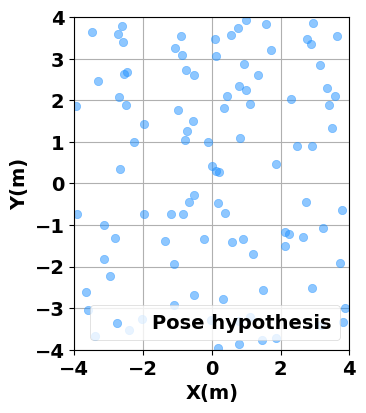

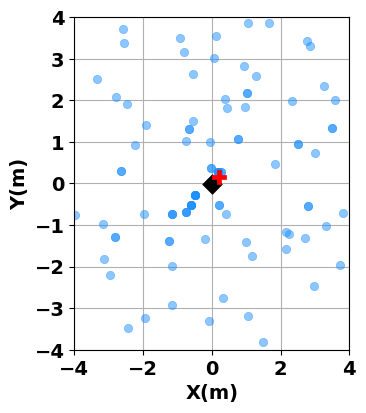

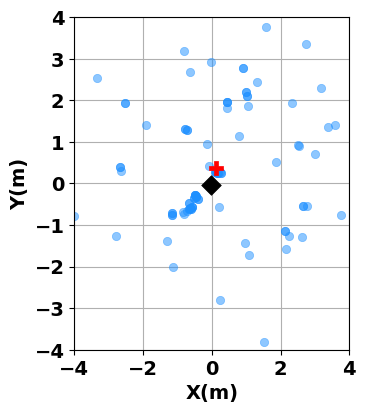

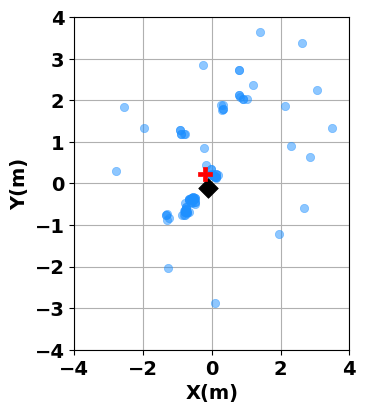

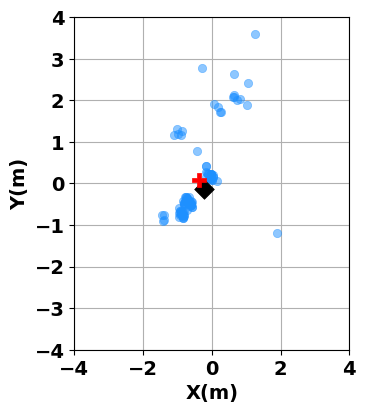

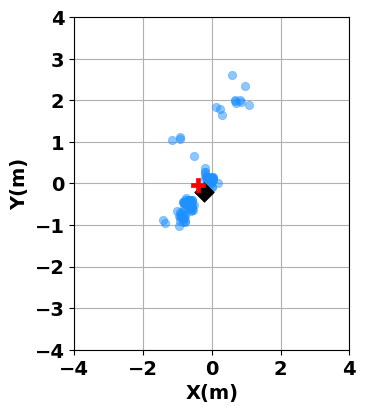

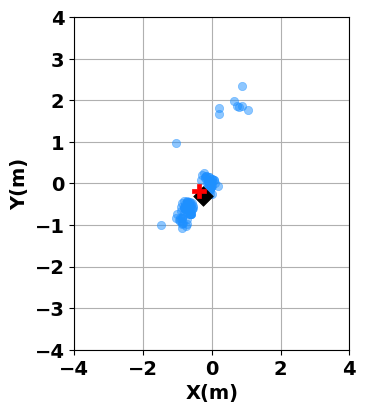

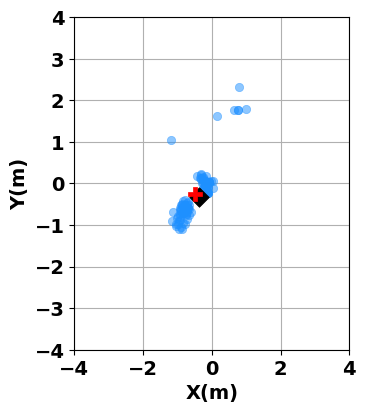

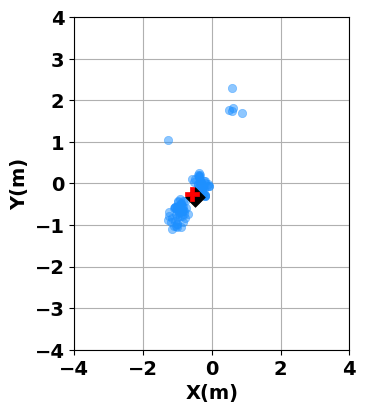

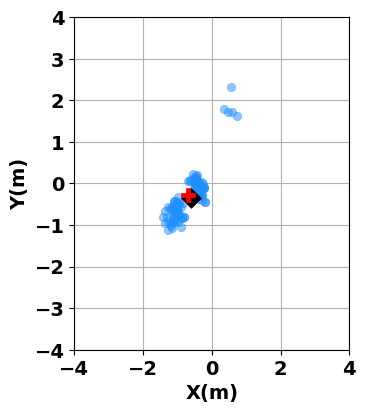

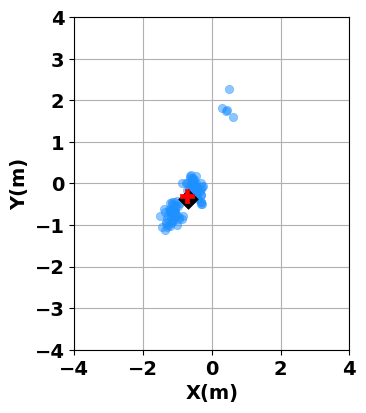

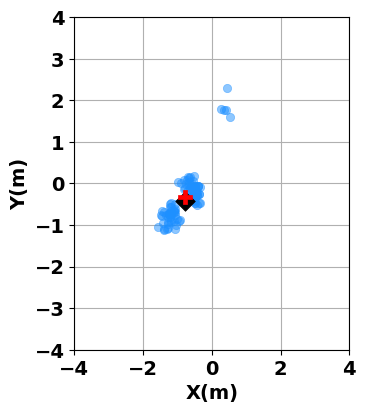

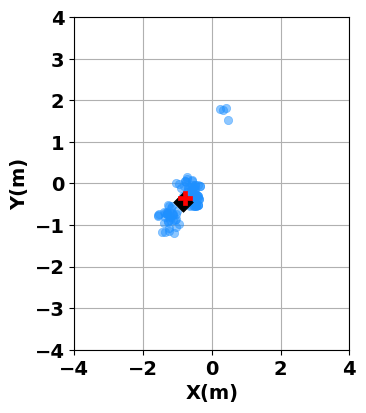

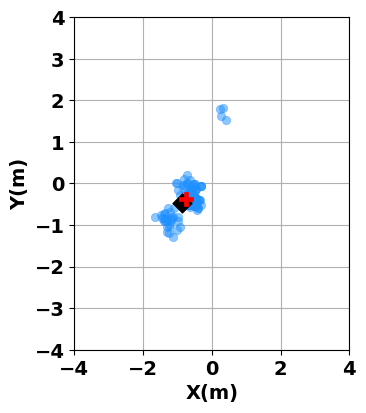

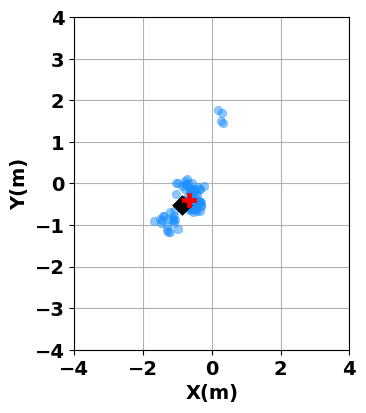

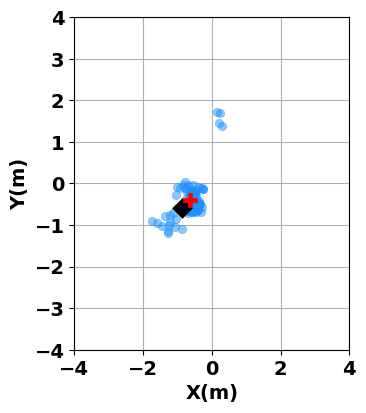

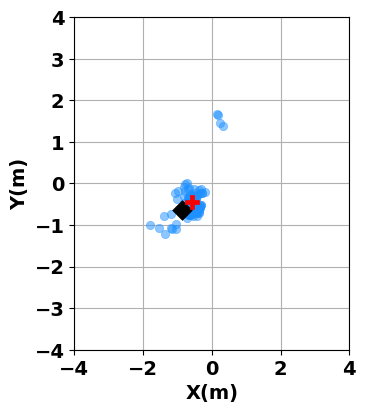

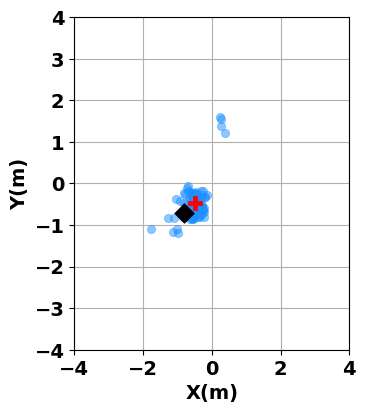

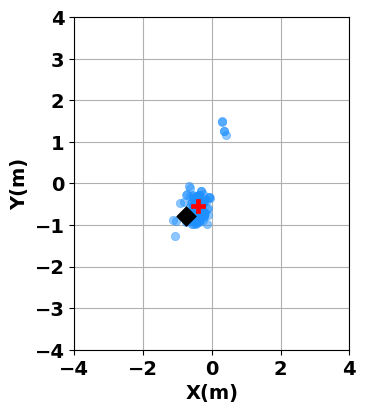

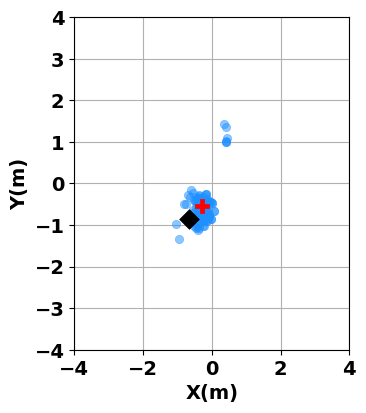

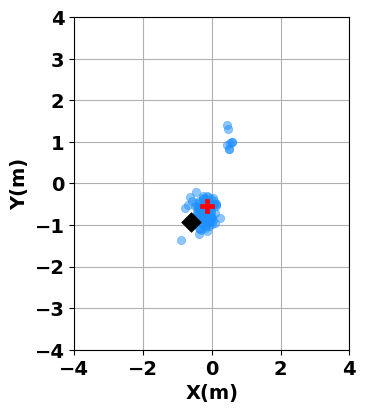

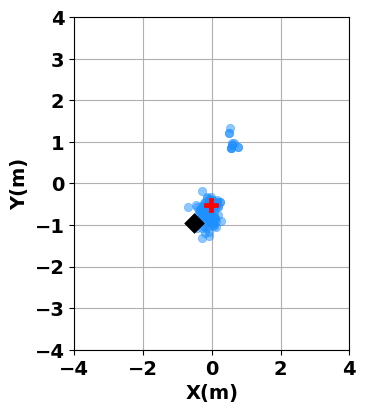

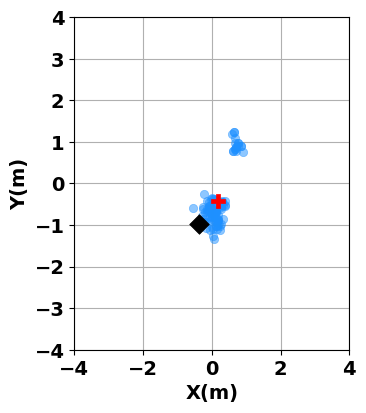

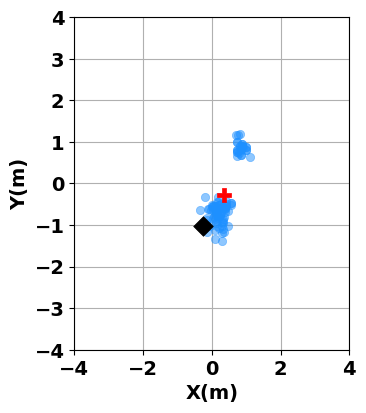

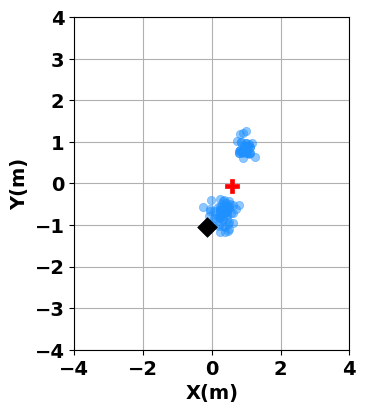

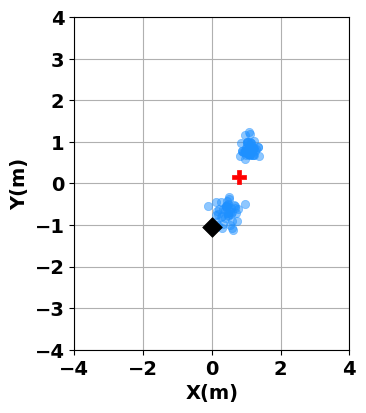

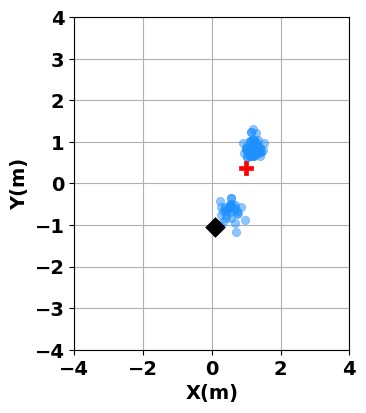

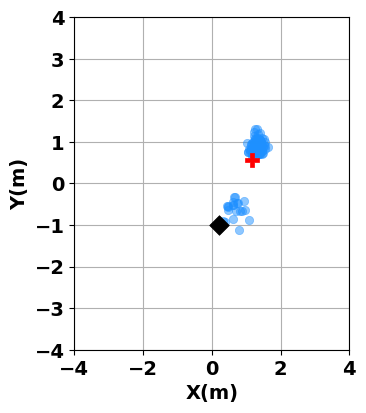

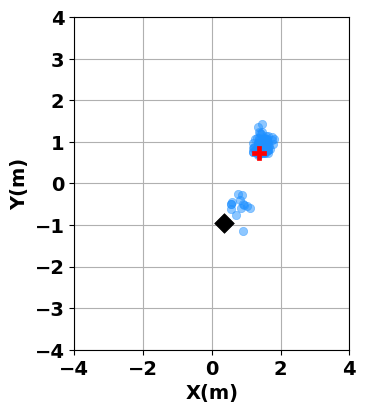

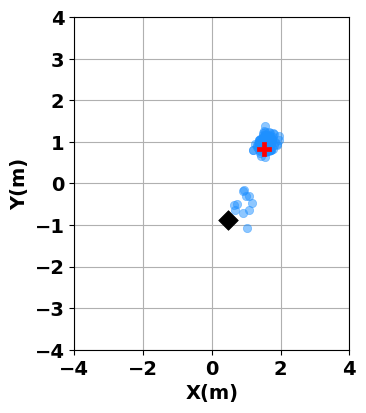

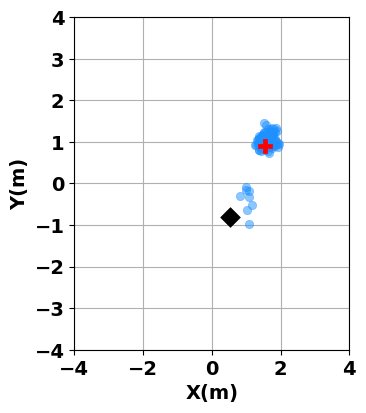

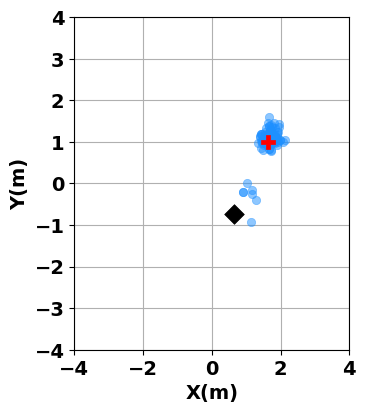

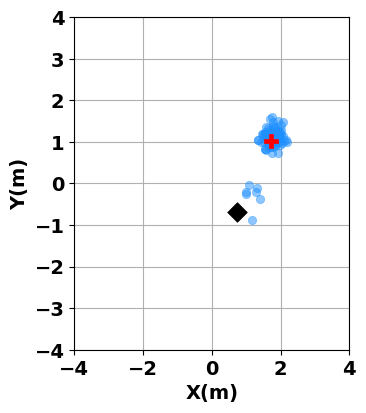

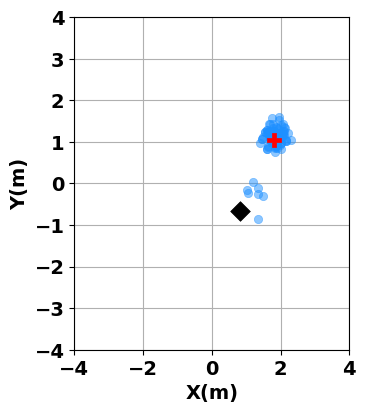

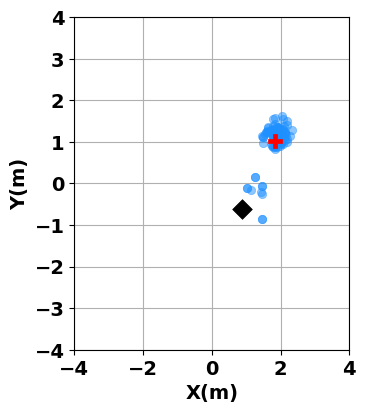

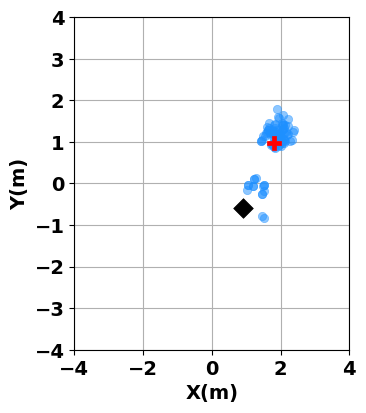

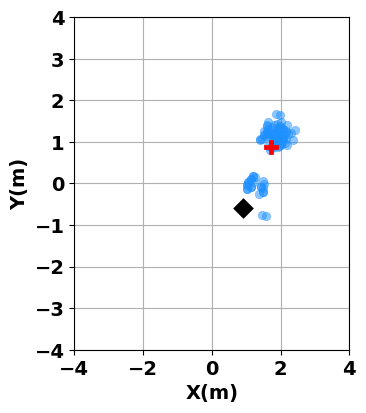

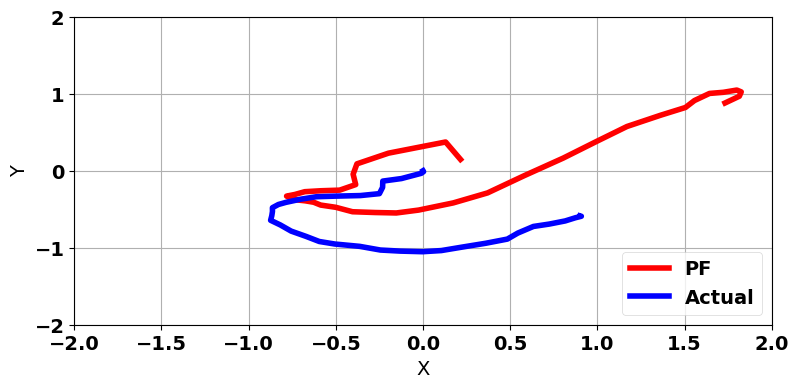

In [11]:
seed(4)
run_pf1(N=100)

In [12]:
pred_pose = np.load("pred_pose_gmm_s12.npy")
true_pose = np.load("true_pose_s12.npy")
print(pred_pose.shape)
print(true_pose.shape)

(36, 3)
(37, 7)


In [13]:
rmse = np.sqrt(mean_squared_error(true_pose[0:pred_pose.shape[0],4:6], pred_pose[:,0:2]))
rmse

0.8407091792530706